In [1]:
# ------------------------------
# 0. Setup
# ------------------------------
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Paths
FEATURE_DIR = "../data/features"

In [3]:
# ------------------------------
# 1. Load all subject data
# ------------------------------
X_list, y_list = [], []

for subj_X_path in glob.glob(os.path.join(FEATURE_DIR, "*_X.npy")):
    subj_id = os.path.basename(subj_X_path).split("_")[0]  # e.g. "A01T"
    subj_y_path = subj_X_path.replace("_X.npy", "_y.npy")

    if not os.path.exists(subj_y_path):
        print(f"Missing labels for {subj_id}, skipping")
        continue

    X_subj = np.load(subj_X_path)
    y_subj = np.load(subj_y_path)

    print(f"Loaded {subj_id}: X={X_subj.shape}, y={y_subj.shape}")

    X_list.append(X_subj)
    y_list.append(y_subj)

# Concatenate across subjects
X = np.vstack(X_list)
y = np.hstack(y_list)

print("Final dataset shape:", X.shape, y.shape)

Loaded A01T: X=(256, 25, 1001), y=(256,)
Loaded A02T: X=(272, 25, 1001), y=(272,)
Loaded A03T: X=(284, 25, 1001), y=(284,)
Loaded A04T: X=(284, 25, 1001), y=(284,)
Loaded A05T: X=(268, 25, 1001), y=(268,)
Loaded A06T: X=(284, 25, 1001), y=(284,)
Loaded A07T: X=(272, 25, 1001), y=(272,)
Loaded A08T: X=(248, 25, 1001), y=(248,)
Loaded A09T: X=(236, 25, 1001), y=(236,)
Final dataset shape: (2404, 25, 1001) (2404,)


In [4]:
# ------------------------------
# 2. Train/Val/Test split
# ------------------------------
# Flatten (channels × timepoints) -> single feature vector per trial
n_trials, n_channels, n_times = X.shape
X_flat = X.reshape(n_trials, n_channels * n_times)

# First split into train+test
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)

# Further split train into train+val
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (1538, 25025) Val: (385, 25025) Test: (481, 25025)


In [5]:
# ------------------------------
# 3. Standardize features
# ------------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


In [8]:
# ------------------------------
# 4. Baseline model (Logistic Regression)
# ------------------------------
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500, solver="lbfgs", multi_class="multinomial")
clf.fit(X_train, y_train)

print("Validation accuracy:", clf.score(X_val, y_val))

c:\Users\steve\anaconda3\envs\py310env\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation accuracy: 0.5974025974025974


Test accuracy: 0.5883575883575883
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       120
           1       0.57      0.57      0.57       120
           2       0.59      0.49      0.53       121
           3       0.61      0.64      0.63       120

    accuracy                           0.59       481
   macro avg       0.59      0.59      0.59       481
weighted avg       0.59      0.59      0.59       481



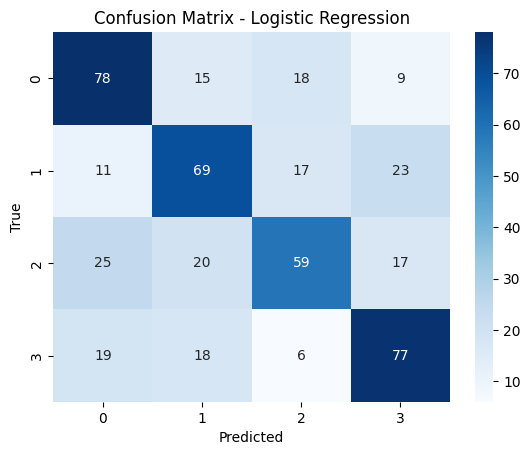

In [10]:
# ------------------------------
# 5. Evaluate on Test
# ------------------------------
y_pred = clf.predict(X_test)
print("Test accuracy:", clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))

# Optional: Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()